In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sksurv.metrics import concordance_index_censored

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

#! pip install lifelines

##### Load Data

In [2]:
HiTIMED_TCGA_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/TCGA_HiTIMED_with_Survival_20240509.csv",
                             index_col=0)
HiTIMED_TCGA_df

,submitter_id,Tumor,Endothelial,Epithelial,Stromal,Bnv,Bmem,CD4nv,CD4mem,Treg,CD8nv,CD8mem,Mono,DC,NK,Bas,Eos,Neu,vital_status,survival_time
277,TCGA-2F-A9KO,59.496435,3.061159,0.000000,4.502154,0.000000,8.404918,0.0,1.838353,1.508797,0.220441,14.009471,0.000000,5.085653,1.872621,0.000000,0.000000,0.000000,1,734.0
96,TCGA-2F-A9KP,77.559634,6.398107,0.079715,3.772901,0.000000,2.361156,0.0,0.237921,1.102857,0.000000,1.418432,0.000000,2.673416,1.764794,0.858058,1.773009,0.000000,1,364.0
301,TCGA-2F-A9KQ,88.570479,1.588447,4.246925,1.060853,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.533296,0.000000,0.000000,0,2886.0
191,TCGA-2F-A9KR,82.046167,5.968081,7.698402,0.615840,0.000000,0.000000,0.0,2.403660,0.000000,0.884687,0.383162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,3183.0
81,TCGA-2F-A9KT,58.215044,5.653344,0.000000,6.824711,0.000000,0.843665,0.0,0.000000,0.000000,0.000000,3.275757,3.080379,6.837927,3.283591,1.241541,0.000000,10.744043,0,2352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,TCGA-ZF-AA56,56.032282,6.010198,6.312032,4.271523,0.000000,6.938654,0.0,3.126088,1.146210,0.000000,3.198236,0.000000,7.094663,0.699691,0.464068,1.607831,3.098525,1,259.0
41,TCGA-ZF-AA58,45.918822,4.505245,0.000000,9.165651,0.000000,3.744179,0.0,4.206508,5.394365,0.000000,1.071090,0.000000,14.456026,3.687531,0.099868,1.865883,5.884833,0,1649.0
79,TCGA-ZF-AA5H,73.982262,1.632842,0.000000,6.839488,2.697143,2.343099,0.0,1.801079,9.184619,0.000000,1.294674,0.000000,0.000000,0.224793,0.000000,0.000000,0.000000,0,897.0
218,TCGA-ZF-AA5N,72.724511,1.721571,0.495669,7.179986,0.000000,4.173312,0.0,0.000000,1.358315,0.000000,0.000000,0.000000,3.327464,4.807795,0.311276,0.297592,3.602511,1,168.0


#### Get Demogrphics and Tumor stage of TCGA

In [3]:
TCGA_Pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/BLCA_TCGA_meta_data.csv").sort_values(by='bcr_patient_barcode', ascending=True).reset_index(drop=True)
TCGA_Pheno.dtypes

bcr_patient_barcode           object
age_at_diagnosis             float64
cigarettes_per_day           float64
primary_diagnosis             object
tissue_or_organ_of_origin     object
ajcc_pathologic_stage         object
race                          object
gender                        object
prior_malignancy              object
vital_status                  object
ajcc_pathologic_t             object
ajcc_pathologic_n             object
ajcc_pathologic_m             object
survival_time                float64
dtype: object

In [4]:
TCGA_Pheno = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/BLCA_TCGA_meta_data.csv").sort_values(by='bcr_patient_barcode', ascending=True).reset_index(drop=True)
TCGA_Pheno = TCGA_Pheno[['bcr_patient_barcode', 'age_at_diagnosis', 'gender', 'ajcc_pathologic_stage']].copy()
TCGA_Pheno.rename({'bcr_patient_barcode': 'submitter_id',
                   'age_at_diagnosis': 'Age',
                   'gender': 'Gender',
                   'ajcc_pathologic_stage': 'Tumor_Stage'}, axis=1, inplace=True)
TCGA_Pheno.replace({'Tumor_Stage': {"0": 'cis_Stage_0',
                                    'Stage I':'Stage_I', 'Stage II':'Stage_II',
                                    'Stage III':'Stage_III', 'Stage IV':'Stage_IV'},
                   'Gender':{'female':0, 'male':1}}, inplace = True)

TCGA_Pheno = TCGA_Pheno.drop_duplicates()

stand = StandardScaler()
TCGA_Pheno['Age_stand'] = stand.fit_transform(TCGA_Pheno['Age'].values.reshape(-1,1))

TCGA_Pheno

,submitter_id,Age,Gender,Tumor_Stage,Age_stand
0,TCGA-2F-A9KO,63.898630,1,Stage_IV,-0.408341
1,TCGA-2F-A9KP,66.926027,1,Stage_IV,-0.135424
2,TCGA-2F-A9KQ,69.202740,1,Stage_III,0.069820
3,TCGA-2F-A9KR,59.857534,0,Stage_III,-0.772643
4,TCGA-2F-A9KT,83.616438,1,Stage_II,1.369205
...,...,...,...,...,...
407,TCGA-ZF-AA56,79.279452,0,Stage_III,0.978229
408,TCGA-ZF-AA58,61.778082,0,Stage_IV,-0.599507
409,TCGA-ZF-AA5H,60.608219,0,Stage_IV,-0.704970
410,TCGA-ZF-AA5N,62.304110,0,Stage_IV,-0.552086


- Standardize Age and convert categorical variables into dummy variables

In [5]:
TCGA_Pheno_Dummy = pd.get_dummies(TCGA_Pheno, columns=['Tumor_Stage'],
                                  drop_first=False, prefix=['Stage'])

TCGA_Pheno_Dummy

,submitter_id,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KQ,69.202740,1,0.069820,0,0,1,0,0
3,TCGA-2F-A9KR,59.857534,0,-0.772643,0,0,1,0,0
4,TCGA-2F-A9KT,83.616438,1,1.369205,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
407,TCGA-ZF-AA56,79.279452,0,0.978229,0,0,1,0,0
408,TCGA-ZF-AA58,61.778082,0,-0.599507,0,0,0,1,0
409,TCGA-ZF-AA5H,60.608219,0,-0.704970,0,0,0,1,0
410,TCGA-ZF-AA5N,62.304110,0,-0.552086,0,0,0,1,0


- Merge Cell proportions and Phenotype

In [6]:
HiTIMED_TCGA_df = HiTIMED_TCGA_df.merge(TCGA_Pheno_Dummy, left_on="submitter_id", right_on="submitter_id", how="left")
HiTIMED_TCGA_df

,submitter_id,Tumor,Endothelial,Epithelial,Stromal,Bnv,Bmem,CD4nv,CD4mem,Treg,...,vital_status,survival_time,Age,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,TCGA-2F-A9KO,59.496435,3.061159,0.000000,4.502154,0.000000,8.404918,0.0,1.838353,1.508797,...,1,734.0,63.898630,1,-0.408341,0,0,0,1,0
1,TCGA-2F-A9KP,77.559634,6.398107,0.079715,3.772901,0.000000,2.361156,0.0,0.237921,1.102857,...,1,364.0,66.926027,1,-0.135424,0,0,0,1,0
2,TCGA-2F-A9KQ,88.570479,1.588447,4.246925,1.060853,0.000000,0.000000,0.0,0.000000,0.000000,...,0,2886.0,69.202740,1,0.069820,0,0,1,0,0
3,TCGA-2F-A9KR,82.046167,5.968081,7.698402,0.615840,0.000000,0.000000,0.0,2.403660,0.000000,...,1,3183.0,59.857534,0,-0.772643,0,0,1,0,0
4,TCGA-2F-A9KT,58.215044,5.653344,0.000000,6.824711,0.000000,0.843665,0.0,0.000000,0.000000,...,0,2352.0,83.616438,1,1.369205,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,TCGA-ZF-AA56,56.032282,6.010198,6.312032,4.271523,0.000000,6.938654,0.0,3.126088,1.146210,...,1,259.0,79.279452,0,0.978229,0,0,1,0,0
391,TCGA-ZF-AA58,45.918822,4.505245,0.000000,9.165651,0.000000,3.744179,0.0,4.206508,5.394365,...,0,1649.0,61.778082,0,-0.599507,0,0,0,1,0
392,TCGA-ZF-AA5H,73.982262,1.632842,0.000000,6.839488,2.697143,2.343099,0.0,1.801079,9.184619,...,0,897.0,60.608219,0,-0.704970,0,0,0,1,0
393,TCGA-ZF-AA5N,72.724511,1.721571,0.495669,7.179986,0.000000,4.173312,0.0,0.000000,1.358315,...,1,168.0,62.304110,0,-0.552086,0,0,0,1,0


In [7]:
HiTIMED_TCGA_df.dtypes

submitter_id          object
Tumor                float64
Endothelial          float64
Epithelial           float64
Stromal              float64
Bnv                  float64
Bmem                 float64
CD4nv                float64
CD4mem               float64
Treg                 float64
CD8nv                float64
CD8mem               float64
Mono                 float64
DC                   float64
NK                   float64
Bas                  float64
Eos                  float64
Neu                  float64
vital_status           int64
survival_time        float64
Age                  float64
Gender                 int64
Age_stand            float64
Stage_Stage_I          uint8
Stage_Stage_II         uint8
Stage_Stage_III        uint8
Stage_Stage_IV         uint8
Stage_cis_Stage_0      uint8
dtype: object

- DH

In [8]:
HiTIMED_DH_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/Bladder_DNAm_HiTIMED/Total_88_subjects_WSI_Pheno_HiTIMED.csv")
HiTIMED_DH_df = HiTIMED_DH_df.drop(['file_name'], axis=1)
HiTIMED_DH_df = HiTIMED_DH_df.drop_duplicates()
HiTIMED_DH_df['TenYearSurv'] = HiTIMED_DH_df['TenYearSurv'].transform(lambda x: x*30)
HiTIMED_DH_df['TenYearRFS'] = HiTIMED_DH_df['TenYearRFS'].transform(lambda x: x*30)


DH_pheno = HiTIMED_DH_df.loc[:,['FFPE.DNA.ID', 'Age', 'Sex', 'stage2']].copy()
DH_pheno.rename({'Sex': 'Gender',
                 'stage2': 'Tumor_Stage'}, axis=1, inplace=True)
DH_pheno.replace({'Tumor_Stage': {"cis + stage 0a": 'cis_Stage_0',
                                  'stage I':'Stage_I', 'stage II':'Stage_II',
                                  'stage III':'Stage_III', 'stage IV':'Stage_IV'},
                  'Gender':{'female':0, 'male':1}}, inplace = True)
DH_pheno['Age_stand'] = stand.transform(DH_pheno['Age'].values.reshape(-1,1))
DH_pheno = pd.get_dummies(DH_pheno, columns=['Tumor_Stage'],
                          drop_first=False, prefix=['Stage'])
DH_pheno = DH_pheno.drop(['Age'], axis=1)

HiTIMED_DH_df = HiTIMED_DH_df.merge(DH_pheno, left_on="FFPE.DNA.ID", right_on="FFPE.DNA.ID", how="left")

HiTIMED_DH_df

,FFPE.DNA.ID,Blood.Sample.ID,ChIP_ID_Blood,Batch,Sex,Age,Grade,Grade2,Muscle_Invasive,BCG,...,Bas,Eos,Neu,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,BLD050,A00000FBK,203723190040_R08C01,Batch_3,male,77,grade 3,Grade 3 + 4,no,Without Immuno,...,0.000000,0.000000,0.000000,1,0.772738,0,0,0,0,1
1,BLD043,A00000FC3,203752100070_R04C01,Batch_2,female,77,grade 3,Grade 3 + 4,no,Without Immuno,...,0.000000,0.000000,0.000000,0,0.772738,1,0,0,0,0
2,BLD061,A00000EH7,203789410029_R03C01,Batch_3,female,76,grade 1,Grade 1 + 2,no,Without Immuno,...,0.073649,0.205418,0.000000,0,0.682589,0,0,0,0,1
3,BLD046,A00000FBS,203734290015_R06C01,Batch_3,male,69,grade 3,Grade 3 + 4,yes,Without Immuno,...,0.483514,2.589137,0.140375,1,0.051544,0,0,0,1,0
4,BLD080,A00000ECL,203751390067_R03C01,Batch_3,male,66,grade 1,Grade 1 + 2,no,Without Immuno,...,0.595428,0.322147,0.000000,1,-0.218904,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,BLD048,BDB1P03023,202163530099_R07C01,Batch_1,male,58,grade 2,Grade 1 + 2,no,Without Immuno,...,0.618560,0.974700,0.000000,1,-0.940099,0,0,0,0,1
84,BLD075,BDB1P04022,202172220150_R06C01,Batch_1,male,51,grade 1,Grade 1 + 2,no,Without Immuno,...,2.200406,0.000000,0.000000,1,-1.571144,0,0,0,0,1
85,BLD024,BDB1P02094,202163530080_R06C01,Batch_1,male,68,grade 1,Grade 1 + 2,no,Without Immuno,...,0.724507,0.487317,0.000000,1,-0.038606,0,0,0,0,1
86,BLD094,BDB1P03058,202163550181_R02C01,Batch_1,male,53,grade 1,Grade 1 + 2,no,Without Immuno,...,0.287847,0.132852,0.000000,1,-1.390845,0,0,0,0,1


In [9]:
# Column names
list(HiTIMED_DH_df.columns)

['FFPE.DNA.ID',
 'Blood.Sample.ID',
 'ChIP_ID_Blood',
 'Batch',
 'Sex',
 'Age',
 'Grade',
 'Grade2',
 'Muscle_Invasive',
 'BCG',
 'ImToBlood',
 'SurgToBlood',
 'SurgToImTx',
 'Smoking',
 'TenDead',
 'TenYearSurv',
 'TenRFS',
 'TenYearRFS',
 'FFPE.Sample.ID',
 'ChIP_ID_FFPE',
 'death_stat',
 'death_censor_time',
 'stage2',
 'RFS_stat',
 'RFS_censor_time',
 'Tumor',
 'Endothelial',
 'Epithelial',
 'Stromal',
 'Bnv',
 'Bmem',
 'CD4nv',
 'CD4mem',
 'Treg',
 'CD8nv',
 'CD8mem',
 'Mono',
 'DC',
 'NK',
 'Bas',
 'Eos',
 'Neu',
 'Gender',
 'Age_stand',
 'Stage_Stage_I',
 'Stage_Stage_II',
 'Stage_Stage_III',
 'Stage_Stage_IV',
 'Stage_cis_Stage_0']

##### Use/Check GPU availability

In [10]:
! nvidia-smi

Tue Jan 14 12:57:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           Off |   00000000:18:00.0 Off |                    0 |
| N/A   36C    P0             41W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

#### Generate Dataset Tensor Object for Training

In [12]:
class TCGA_HiTIMED_Dataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe
        #self.cell_types = pd.concat([dataframe.loc[:, 'Tumor':'Neu'], dataframe.loc[:, 'Age_stand':'Stage_cis_Stage_0']], axis=1) # inputs/features
        self.cell_types = dataframe.loc[:, 'Tumor':'Neu']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        self.death = dataframe['survival_time'] # ouput
        self.status = dataframe['vital_status'] # output
        
    def __len__(self):
        return len(self.df.index)
        
    def __getitem__(self, idx):
        cell_types = torch.tensor(self.cell_types.iloc[idx])
        demographic = torch.tensor(self.demographic.iloc[idx])
        death = torch.tensor(int(float(self.death.iloc[idx])))
        status = torch.tensor(self.status.iloc[idx])
        return cell_types, demographic, death, status

In [13]:
TCGA_HiTIMED_Data = TCGA_HiTIMED_Dataset(HiTIMED_TCGA_df)

##### Split Dataset into training, and validation set

In [14]:
indices = torch.randperm(len(TCGA_HiTIMED_Data)).tolist()

# training:testing = 80%:20%
dataset_train = torch.utils.data.Subset(TCGA_HiTIMED_Data, indices[:-80])
dataset_val = torch.utils.data.Subset(TCGA_HiTIMED_Data, indices[-80:])

#### Generate Dataset Tensor Object for Testing

In [15]:
class DH_HiTIMED_Dataset(Dataset):
    def __init__(self, dataframe, recurrence = False):
        self.df = dataframe
        #self.cell_types = pd.concat([dataframe.loc[:, 'Tumor':'Neu'], dataframe.loc[:, 'Age_stand':'Stage_cis_Stage_0']], axis=1) # inputs/features
        self.cell_types = dataframe.loc[:, 'Tumor':'Neu']
        self.demographic = dataframe.loc[:, 'Gender':'Stage_cis_Stage_0']
        if recurrence:
            self.death = dataframe['RFS_censor_time'] # ouput
            self.status = dataframe['RFS_stat']
        else:
            self.death = dataframe['death_censor_time'] # ouput
            self.status = dataframe['death_stat'] # output
        
    def __len__(self):
        return len(self.df.index)
        
    def __getitem__(self, idx):
        cell_types = torch.tensor(self.cell_types.iloc[idx])
        demographic = torch.tensor(self.demographic.iloc[idx])
        death = torch.tensor(int(float(self.death.iloc[idx])))
        status = torch.tensor(self.status.iloc[idx])
        return cell_types, demographic, death, status

In [16]:
DH_HiTIMED_Data = DH_HiTIMED_Dataset(HiTIMED_DH_df)
DH_HiTIMED_Data_recurrence = DH_HiTIMED_Dataset(HiTIMED_DH_df, recurrence = True)

##### Check one of subjects

In [17]:
dataset_train.__getitem__(2)

(tensor([72.7245,  1.7216,  0.4957,  7.1800,  0.0000,  4.1733,  0.0000,  0.0000,
          1.3583,  0.0000,  0.0000,  0.0000,  3.3275,  4.8078,  0.3113,  0.2976,
          3.6025], dtype=torch.float64),
 tensor([ 0.0000, -0.5521,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        dtype=torch.float64),
 tensor(168),
 tensor(1))

In [18]:
DH_HiTIMED_Data.__getitem__(2)

(tensor([61.1459,  2.8884, 13.7729,  5.8588,  0.0000,  3.5362,  0.0000,  0.9980,
          1.5898,  0.0000,  3.1419,  0.0000,  4.5348,  2.2543,  0.0736,  0.2054,
          0.0000], dtype=torch.float64),
 tensor([0.0000, 0.6826, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        dtype=torch.float64),
 tensor(3780),
 tensor(0))

In [19]:
DH_HiTIMED_Data_recurrence.__getitem__(2)

(tensor([61.1459,  2.8884, 13.7729,  5.8588,  0.0000,  3.5362,  0.0000,  0.9980,
          1.5898,  0.0000,  3.1419,  0.0000,  4.5348,  2.2543,  0.0736,  0.2054,
          0.0000], dtype=torch.float64),
 tensor([0.0000, 0.6826, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        dtype=torch.float64),
 tensor(3780),
 tensor(0))

##### Check Length

In [17]:
print(len(dataset_train))
print(len(dataset_val))

315
80


#### Setting Data Loader

In [18]:
batch_size = 64

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_train_for_cindex = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
data_loader_val = DataLoader(dataset_val, batch_size=len(dataset_val), shuffle=False)

In [19]:
data_loader_test = DataLoader(DH_HiTIMED_Data, batch_size=len(DH_HiTIMED_Data), shuffle=False)
data_loader_test_recurrence = DataLoader(DH_HiTIMED_Data_recurrence, batch_size=len(DH_HiTIMED_Data_recurrence), shuffle=False)

#### Define Loss (Cox Loss)

In [20]:
def cox_loss(survtime, censor, hazard_pred, device):
    # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
    # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data
    #current_batch_len = len(survtime)
    #hazard_pred = hazard_pred.to(device)
    
    current_batch_len = len(censor)
    R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
    for i in range(current_batch_len):
        for j in range(current_batch_len):
            R_mat[i,j] = survtime[j] >= survtime[i]
    R_mat = torch.FloatTensor(R_mat).to(device)
    theta = hazard_pred.reshape(-1)
    exp_theta = torch.exp(theta)
    loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * censor.to(device))
    return loss_cox

#### Define c-index

In [21]:
def c_index(loader,model,device):
    for batch_idx,data in enumerate(loader):
        censors = data[3]
        times = data[2]
        
        data1 = data[0].float().to(device)
        data2 = data[1].float().to(device)
        
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(data1.isnan()):
            data1 = torch.nan_to_num(data1)
        if torch.any(data2.isnan()):
            data2 = torch.nan_to_num(data2)
        hazards = model(data1, data2)
        censors = censors.cpu().detach().numpy()
        times = times.cpu().detach().numpy()
        hazards = hazards.cpu().detach().numpy().reshape((-1,))
        # change so it goes thru all batches
        censors = censors.astype(bool)
        cidx = concordance_index_censored(censors,times,hazards)
        # The return of concordance_index_censored: (cindex, concordant, discordant, tied_risk, tied_time)
        cidx_value = cidx[0]
        return cidx_value

#### Evaluation Function

In [22]:
def evaluate(model,loader,device):
    total_loss = 0
    model.train(False)
    with torch.no_grad():
        for idx,data in enumerate(loader):
            censors = data[3]
            times = data[2]
            data1 = data[0].float().to(device)
            data2 = data[1].float().to(device)
            if torch.any(censors.isnan()):
                censors = torch.nan_to_num(censors)
            if torch.any(times.isnan()):
                times = torch.nan_to_num(times)
            if torch.any(data1.isnan()):
                data1 = torch.nan_to_num(data1)
            if torch.any(data2.isnan()):
                data2 = torch.nan_to_num(data2)
            hazard_pred = model(data1,data2)
            loss = cox_loss(times ,censors, hazard_pred, device)
            total_loss+=loss.item()
    model.train(True)
    return total_loss/len(loader)

#### Define Interaction Function

In [23]:
def self_outer(x):
    return torch.einsum('bi,bj->bij',x,x).reshape(x.shape[0],-1)

def outer(x,y):
    return torch.einsum('bi,bj->bij',x,y).reshape(x.shape[0],-1)

#### Building Networks

In [24]:
class HiTIMED_MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(HiTIMED_MLP, self).__init__()
        
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        self.hidden_layers = nn.ModuleList()
        
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x, y):
#         x/=100.
        x = outer(x, y)
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            #x = self.dropout(self.relu(layer(x)))
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x

#### Building Networks for extracting the layer before the output layer

In [25]:
class HiTIMED_Pred(HiTIMED_MLP):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(HiTIMED_Pred, self).__init__(input_size, hidden_sizes, output_size)
        
    def forward(self, x):
        x = self.relu(self.input_layer(x))
        for layer in self.hidden_layers[:-1]:
            x = self.dropout(self.relu(layer(x)))
        return self.hidden_layers[-1](x)        

#### Training Setting

In [26]:
input_size = len(dataset_train.__getitem__(2)[0])*len(dataset_train.__getitem__(2)[1])
#hidden_sizes = [64, 64, 64, 64]
# hidden_sizes = [512, 256, 256, 256, 256] # original
hidden_sizes=[64,32,32]
output_size = 1
model = HiTIMED_MLP(input_size, hidden_sizes, output_size).to(device)

loss_fn = cox_loss

learning_rate = 0.01
num_epochs = 100  # more than 500 doesn't change c-index and loss a lot
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-1)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)

# Decays the learning rate of each parameter group by gamma every step_size epochs.
#StepLR(optimizer, step_size=1, gamma=0.99)

# Other schedulers
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,10,eta_min=1e-7)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,20,eta_min=5e-5, T_mult = 2)

### Training

- make saving director

In [33]:
#! mkdir /dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/Model_Saving/No_Dropout_with_AgeStandSexStage_CellPhenoInteraction

In [34]:
ftrain_losses = []
fval_losses = []
ftrain_c_indices = []
fval_c_indices = []
ftest_c_indices = []
ftest_c_indices_recurrence = []
best_val_cox = 0
lambda_l1=1e-4 # for regularization
best_model_dict = copy.deepcopy(model).cpu().state_dict()
save_dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/Model_Saving/No_Dropout_with_AgeStandSexStage_CellPhenoInteraction'

for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    model.train()
    for batch_num, input_data in enumerate(data_loader_train):
        optimizer.zero_grad()
        
        x, x2, y_time, y_status = input_data
        x = x.to(device).float() # Immune Profiles
        x2 = x2.to(device).float() # Demorgraphic and Stage
        y_time = y_time.to(device).float() # Time
        y_status = y_status.to(device).float() # Outcome or not
        output = model(x, x2)
        loss = loss_fn(y_time, y_status, output, device)
        #l1_reg = torch.tensor(0.).to(device) # for regularization
        #for param in model.parameters(): # for regularization
         #   l1_reg+=torch.norm(param,p=1) # for regularization
        train_losses.append(loss.item())
        #loss+=lambda_l1*l1_reg # for regularization
            
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        if batch_num % 1 == 0: print('\tEpoch %d | Batch %d | Loss %6.2f'  % (epoch, batch_num, loss.item()))
    
    # Calculate train loss for the Epoch
    train_loss = sum(train_losses)/len(train_losses)
    ftrain_losses.append(train_loss)
    print('epoch:' + str(epoch))
    print('train loss: ' + str(train_loss))
    
    # Calculate validation set loss for the Epoch
    model.eval()
    val_loss = evaluate(model, data_loader_val, device)
    print('val loss: ' + str(val_loss))
    
    fval_losses.append(val_loss)
    
    # Calculate val and test c-index for the Epoch
    cidx_train = c_index(data_loader_train_for_cindex, model, device)
    cidx_val = c_index(data_loader_val, model, device)
    cidx_test = c_index(data_loader_test, model, device)
    cidx_test_recurrence = c_index(data_loader_test_recurrence, model, device)
    
    print('train c-index: ' + str(cidx_train))
    print('val c-index: ' + str(cidx_val))
    print('test c-index: ' + str(cidx_test))
    print('test c-index (for recurrence): ' + str(cidx_test_recurrence))
    
    # Record the best model info.
    if cidx_val > best_val_cox:
        best_model_dict=copy.deepcopy(model).cpu().state_dict()
        best_val_cox=cidx_val
        torch.save(model.state_dict(), save_dir + '/model_best' + '.pth')
        print('____________________________Got new best____________________________')
    else:
        pass
    
    ftrain_c_indices.append(cidx_train)
    fval_c_indices.append(cidx_val)
    ftest_c_indices.append(cidx_test)
    ftest_c_indices_recurrence.append(cidx_test_recurrence)
    
    # Record metrics
    f = open(save_dir + '/training_history.txt','a')
    f.write('Epoch ' + str(epoch) + " Train Loss: " + str(train_loss) + " Val Loss: " + str(val_loss) + 
            " Val cidx: " + str(cidx_val) + " Test c-index: " + str(cidx_test) +  
            " Test c-index (for recurrence): " + str(cidx_test_recurrence) + "\n")
    
    
    # Save model
    if epoch % 10 == 0:
        torch.save(model.state_dict(), save_dir + '/model_epoch_' + str(epoch) + '.pth')
    
    scheduler.step()

	Epoch 0 | Batch 0 | Loss   1.52
	Epoch 0 | Batch 1 | Loss   1.49
	Epoch 0 | Batch 2 | Loss   1.51
	Epoch 0 | Batch 3 | Loss   1.23
	Epoch 0 | Batch 4 | Loss   1.53
epoch:0
train loss: 1.4555837392807007
val loss: 1.683693528175354
train c-index: 0.7039762611275965
val c-index: 0.6039215686274509
test c-index: 0.5982627578718784
test c-index (for recurrence): 0.5400058190282223
____________________________Got new best____________________________
	Epoch 1 | Batch 0 | Loss   1.68
	Epoch 1 | Batch 1 | Loss   1.45
	Epoch 1 | Batch 2 | Loss   1.28
	Epoch 1 | Batch 3 | Loss   1.14
	Epoch 1 | Batch 4 | Loss   1.58
epoch:1
train loss: 1.4234878778457642
val loss: 1.7015026807785034
train c-index: 0.7078931750741839
val c-index: 0.5871148459383754
test c-index: 0.5960912052117264
test c-index (for recurrence): 0.5513529240616817
	Epoch 2 | Batch 0 | Loss   1.35
	Epoch 2 | Batch 1 | Loss   1.32
	Epoch 2 | Batch 2 | Loss   1.52
	Epoch 2 | Batch 3 | Loss   1.39
	Epoch 2 | Batch 4 | Loss   1.44
epo

	Epoch 20 | Batch 2 | Loss   0.83
	Epoch 20 | Batch 3 | Loss   1.35
	Epoch 20 | Batch 4 | Loss   1.24
epoch:20
train loss: 1.1813410758972167
val loss: 1.9559195041656494
train c-index: 0.8174876360039565
val c-index: 0.6767507002801121
test c-index: 0.6355410785378212
test c-index (for recurrence): 0.5554262438172826
	Epoch 21 | Batch 0 | Loss   1.18
	Epoch 21 | Batch 1 | Loss   1.25
	Epoch 21 | Batch 2 | Loss   1.59
	Epoch 21 | Batch 3 | Loss   1.17
	Epoch 21 | Batch 4 | Loss   1.42
epoch:21
train loss: 1.322765016555786
val loss: 1.803247094154358
train c-index: 0.7791493570722058
val c-index: 0.638095238095238
test c-index: 0.6532754252623959
test c-index (for recurrence): 0.560081466395112
	Epoch 22 | Batch 0 | Loss   1.11
	Epoch 22 | Batch 1 | Loss   1.56
	Epoch 22 | Batch 2 | Loss   1.67
	Epoch 22 | Batch 3 | Loss   1.01
	Epoch 22 | Batch 4 | Loss   1.38
epoch:22
train loss: 1.34507896900177
val loss: 2.028201103210449
train c-index: 0.7656973293768546
val c-index: 0.65322128851

	Epoch 41 | Batch 1 | Loss   0.78
	Epoch 41 | Batch 2 | Loss   0.88
	Epoch 41 | Batch 3 | Loss   1.24
	Epoch 41 | Batch 4 | Loss   0.95
epoch:41
train loss: 0.9554742217063904
val loss: 2.3118793964385986
train c-index: 0.914698318496538
val c-index: 0.6829131652661065
test c-index: 0.672819399203764
test c-index (for recurrence): 0.5728833284841431
	Epoch 42 | Batch 0 | Loss   1.02
	Epoch 42 | Batch 1 | Loss   0.94
	Epoch 42 | Batch 2 | Loss   0.76
	Epoch 42 | Batch 3 | Loss   1.12
	Epoch 42 | Batch 4 | Loss   0.75
epoch:42
train loss: 0.9183924436569214
val loss: 2.457589864730835
train c-index: 0.9186152324431256
val c-index: 0.6840336134453782
test c-index: 0.6757148027506333
test c-index (for recurrence): 0.5769566482397439
	Epoch 43 | Batch 0 | Loss   0.71
	Epoch 43 | Batch 1 | Loss   0.99
	Epoch 43 | Batch 2 | Loss   0.82
	Epoch 43 | Batch 3 | Loss   1.14
	Epoch 43 | Batch 4 | Loss   0.92
epoch:43
train loss: 0.9143665313720704
val loss: 2.5371692180633545
train c-index: 0.91750

train c-index: 0.8271018793273986
val c-index: 0.638095238095238
test c-index: 0.6811436844010134
test c-index (for recurrence): 0.5696828629618854
	Epoch 63 | Batch 0 | Loss   1.34
	Epoch 63 | Batch 1 | Loss   1.06
	Epoch 63 | Batch 2 | Loss   1.22
	Epoch 63 | Batch 3 | Loss   1.13
	Epoch 63 | Batch 4 | Loss   1.26
epoch:63
train loss: 1.2012134075164795
val loss: 2.029320478439331
train c-index: 0.815944609297725
val c-index: 0.6532212885154062
test c-index: 0.6851248642779587
test c-index (for recurrence): 0.5725923770730288
	Epoch 64 | Batch 0 | Loss   1.40
	Epoch 64 | Batch 1 | Loss   1.21
	Epoch 64 | Batch 2 | Loss   1.23
	Epoch 64 | Batch 3 | Loss   1.17
	Epoch 64 | Batch 4 | Loss   0.94
epoch:64
train loss: 1.1906828165054322
val loss: 1.9333637952804565
train c-index: 0.8485459940652819
val c-index: 0.6677871148459383
test c-index: 0.6894679695982627
test c-index (for recurrence): 0.5699738143729997
	Epoch 65 | Batch 0 | Loss   1.05
	Epoch 65 | Batch 1 | Loss   1.44
	Epoch 65 

	Epoch 84 | Batch 0 | Loss   0.75
	Epoch 84 | Batch 1 | Loss   1.11
	Epoch 84 | Batch 2 | Loss   1.08
	Epoch 84 | Batch 3 | Loss   0.81
	Epoch 84 | Batch 4 | Loss   0.58
epoch:84
train loss: 0.8653233647346497
val loss: 2.5603630542755127
train c-index: 0.9379228486646884
val c-index: 0.6784313725490196
test c-index: 0.6742671009771987
test c-index (for recurrence): 0.5638638347395984
	Epoch 85 | Batch 0 | Loss   0.65
	Epoch 85 | Batch 1 | Loss   0.63
	Epoch 85 | Batch 2 | Loss   0.96
	Epoch 85 | Batch 3 | Loss   0.82
	Epoch 85 | Batch 4 | Loss   1.11
epoch:85
train loss: 0.8348145604133606
val loss: 3.094761610031128
train c-index: 0.9384767556874382
val c-index: 0.6873949579831933
test c-index: 0.6796959826275787
test c-index (for recurrence): 0.5641547861507128
	Epoch 86 | Batch 0 | Loss   0.86
	Epoch 86 | Batch 1 | Loss   0.59
	Epoch 86 | Batch 2 | Loss   0.92
	Epoch 86 | Batch 3 | Loss   0.71
	Epoch 86 | Batch 4 | Loss   0.94
epoch:86
train loss: 0.8042032480239868
val loss: 3.078

- Best Epoch: 39

### Plotting

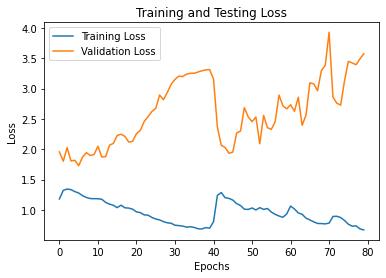

In [35]:
plt.plot(ftrain_losses[20:], label='Training Loss')
plt.plot(fval_losses[20:], label='Validation Loss')
# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

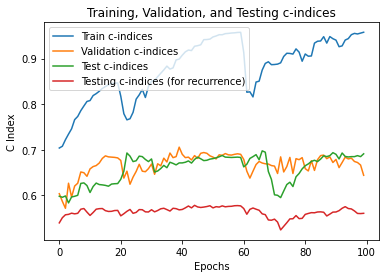

In [36]:
plt.plot(ftrain_c_indices, label='Train c-indices')
plt.plot(fval_c_indices, label='Validation c-indices')
plt.plot(ftest_c_indices, label='Test c-indices')
plt.plot(ftest_c_indices_recurrence, label='Testing c-indices (for recurrence)')
plt.xlabel('Epochs')
plt.ylabel('C Index')
plt.title('Training, Validation, and Testing c-indices')
plt.legend()
plt.show()

# Interpretation

##### Load trained model

In [27]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/Model_Saving/No_Dropout_with_AgeStandSexStage_CellPhenoInteraction/model_best.pth')

##### Load trained model

In [28]:
model.load_state_dict(best_state_dict)

<All keys matched successfully>

##### Initialize IG object

In [31]:
ig = IntegratedGradients(model)

##### Compute total attribution

In [41]:
total_attr = []
for batch in data_loader_test:
    x, x2, y_time, y_status = batch
    x = x.to(device).float() # Immune Profiles
    x2 = x2.to(device).float() # Demorgraphic and Stage
    attr = ig.attribute((x, x2))
    total_attr.append(attr)

In [44]:
total_attr

[(tensor([[ 5.4810e-02,  3.0128e-01, -3.4498e-02,  ..., -0.0000e+00,
           -0.0000e+00, -0.0000e+00],
          [-5.9409e+00, -8.7616e-01, -5.9648e-01,  ..., -0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 1.1341e+00, -8.4867e-02,  2.7965e-01,  ..., -6.9492e-03,
           -3.5922e-03,  0.0000e+00],
          ...,
          [-2.2142e-01,  3.9432e-02, -1.2915e-03,  ..., -6.9339e-02,
            7.2523e-03, -0.0000e+00],
          [-5.9395e+00,  8.9616e-02,  2.3274e-02,  ..., -7.0176e-02,
           -3.8383e-02, -0.0000e+00],
          [-2.3994e-01,  1.8564e-02,  5.6503e-03,  ..., -1.2672e-01,
            3.3033e-03, -0.0000e+00]], device='cuda:0', dtype=torch.float64),
  tensor([[-3.6826e-01,  7.5707e-01,  0.0000e+00,  0.0000e+00, -0.0000e+00,
           -0.0000e+00,  5.7228e-02],
          [ 0.0000e+00,  4.5002e+00, -1.1710e+01, -0.0000e+00, -0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-0.0000e+00,  2.5725e-01, -0.0000e+00, -0.0000e+00,  0.0000e+00,

##### Get the HiTIMED Attribution of each patient

In [64]:
HiTIMED_Attri = pd.DataFrame(total_attr[0][0].cpu().numpy())

# Get column names
HiTIMED_Attri.columns = list(HiTIMED_DH_df.columns)[25:42]

HiTIMED_Attri

,Tumor,Endothelial,Epithelial,Stromal,Bnv,Bmem,CD4nv,CD4mem,Treg,CD8nv,CD8mem,Mono,DC,NK,Bas,Eos,Neu
0,0.054810,0.301276,-0.034498,0.362132,-0.0,0.142026,0.0,-0.000000,-0.501805,0.0,0.136018,-0.000000,0.000000,-0.013918,-0.000000,-0.000000,-0.000000
1,-5.940873,-0.876155,-0.596484,-0.895005,-0.0,0.539987,-0.0,0.026496,0.311285,0.0,-0.164250,-0.100298,0.521328,-0.036207,-0.000000,0.000000,0.000000
2,1.134103,-0.084867,0.279650,-0.069134,-0.0,0.206928,-0.0,0.075244,0.055369,-0.0,-0.040746,0.000000,-0.144365,-0.190155,-0.006949,-0.003592,0.000000
3,-0.133874,0.041757,-0.000000,0.091738,-0.0,-0.074054,0.0,-0.039674,-0.066836,0.0,0.087318,0.000000,0.133513,0.063757,-0.010120,-0.066435,0.000216
4,-0.334090,0.053513,-0.023435,-0.123514,0.0,0.247482,0.0,-0.039900,-0.066461,0.0,0.000000,-0.046867,0.000000,0.000000,-0.070169,-0.001459,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,-4.841129,0.231473,0.305601,-0.154406,0.0,0.319185,0.0,-0.266759,-0.185364,-0.0,0.391110,-0.000000,0.000000,0.228600,-0.138845,-0.132741,-0.000000
84,-9.318462,0.467530,0.482986,-0.317109,0.0,0.276060,0.0,-0.138808,-0.434501,-0.0,0.000000,-0.000000,-0.000000,0.000000,-0.168414,-0.000000,-0.000000
85,-0.221422,0.039432,-0.001291,0.000550,0.0,0.144500,0.0,0.002268,-0.086241,0.0,0.064364,-0.198964,0.000000,0.038387,-0.069339,0.007252,-0.000000
86,-5.939496,0.089616,0.023274,-0.854679,0.0,0.383628,0.0,-0.067144,-0.101605,-0.0,0.072177,-0.152618,-0.000000,0.000000,-0.070176,-0.038383,-0.000000


- Bar Plot for Attribution of Immune Proportions

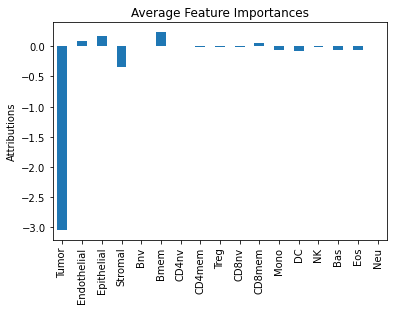

In [77]:
HiTIMED_Attri.mean(axis = 0).plot(kind='bar')
plt.title('Average Feature Importances')
plt.ylabel('Attributions')
plt.show()

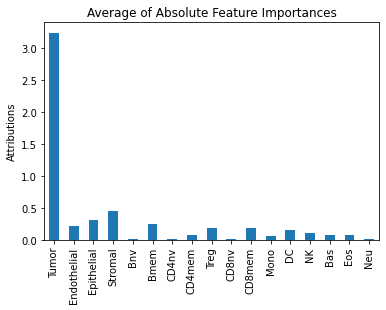

In [78]:
HiTIMED_Attri.abs().mean(axis = 0).plot(kind='bar')
plt.title('Average of Absolute Feature Importances')
plt.ylabel('Attributions')
plt.show()

##### Get the Demographic Attribution of each patient

In [73]:
Demogr_Attri = pd.DataFrame(total_attr[0][1].cpu().numpy())

# Get column names
Demogr_Attri.columns = list(HiTIMED_DH_df.columns)[42:49]

Demogr_Attri

,Gender,Age_stand,Stage_Stage_I,Stage_Stage_II,Stage_Stage_III,Stage_Stage_IV,Stage_cis_Stage_0
0,-0.368262,0.757074,0.000000,0.0,-0.0,-0.000000,0.057228
1,0.000000,4.500182,-11.710359,-0.0,-0.0,0.000000,0.000000
2,-0.000000,0.257250,-0.000000,-0.0,0.0,0.000000,0.954236
3,0.031290,0.013118,-0.000000,-0.0,-0.0,-0.017103,0.000000
4,0.013989,-0.373015,-0.000000,0.0,0.0,0.000000,-0.045875
...,...,...,...,...,...,...,...
83,-0.196084,-6.048173,-0.000000,0.0,0.0,0.000000,2.000982
84,-0.117284,-9.401574,-0.000000,-0.0,0.0,0.000000,0.368140
85,-0.724235,-0.071386,-0.000000,0.0,0.0,0.000000,0.515118
86,1.794952,-7.670394,-0.000000,0.0,0.0,0.000000,-0.779964


- Bar Plot for Attribution of Demographics

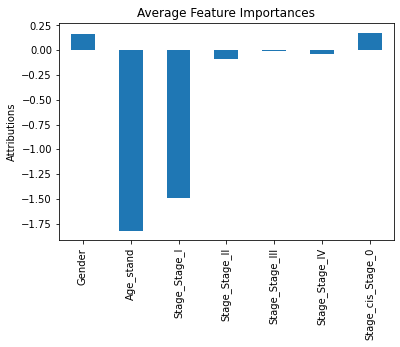

In [79]:
Demogr_Attri.mean(axis = 0).plot(kind='bar')
plt.title('Average Feature Importances')
plt.ylabel('Attributions')
plt.show()

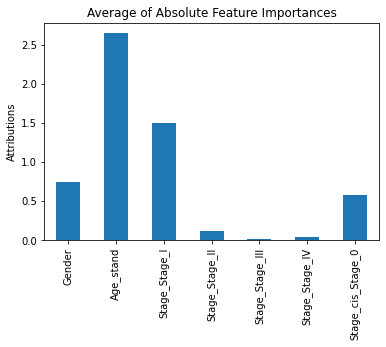

In [80]:
Demogr_Attri.abs().mean(axis = 0).plot(kind='bar')
plt.title('Average of Absolute Feature Importances')
plt.ylabel('Attributions')
plt.show()

# Get the predicted hazard of DH dataset

##### Build prediction model

In [30]:
input_size = len(dataset_train.__getitem__(2)[0])*len(dataset_train.__getitem__(2)[1])
hidden_sizes=[64,32,32]
output_size = 1
prediction_model = HiTIMED_MLP(input_size, hidden_sizes, output_size).to(device)

##### Load trained model

In [32]:
best_state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/Model_Saving/No_Dropout_with_AgeStandSexStage_CellPhenoInteraction/model_best.pth')

In [33]:
prediction_model.load_state_dict(best_state_dict)

<All keys matched successfully>

### Get hazards

In [34]:
prediction_model.eval()
prediction_model.train(False)
with torch.no_grad():
    for idx,data in enumerate(data_loader_test):
        censors = data[3]
        times = data[2]
        data1 = data[0].float().to(device)
        data2 = data[1].float().to(device)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(data1.isnan()):
            data1 = torch.nan_to_num(data1)
        if torch.any(data2.isnan()):
            data2 = torch.nan_to_num(data2)        
        hazards_pred = prediction_model(data1,data2)

### Merge to the original data frame

In [36]:
predicted_df = HiTIMED_DH_df[['FFPE.DNA.ID','Blood.Sample.ID','death_stat','death_censor_time','TenDead','TenYearSurv','RFS_stat','RFS_censor_time','TenRFS','TenYearRFS','Sex','Age']].copy()
predicted_hazards = hazards_pred.cpu().numpy()
predicted_df['predicted_hazard_HiTIMED'] = predicted_hazards
predicted_df

,FFPE.DNA.ID,Blood.Sample.ID,death_stat,death_censor_time,TenDead,TenYearSurv,RFS_stat,RFS_censor_time,TenRFS,TenYearRFS,Sex,Age,predicted_hazard_HiTIMED
0,BLD050,A00000FBK,1,3816.344970,0,3600.000000,1,3816.344970,0,3600.000000,male,77,0.995584
1,BLD043,A00000FC3,1,4869.979467,0,3600.000000,1,4869.979467,0,3600.000000,female,77,-14.279065
2,BLD061,A00000EH7,0,3780.000000,0,3600.000000,0,3780.000000,0,3600.000000,female,76,2.538335
3,BLD046,A00000FBS,1,2991.375770,1,2991.375770,1,2991.375770,1,2991.375770,male,69,0.173567
4,BLD080,A00000ECL,1,1392.689939,1,1392.689939,1,1392.689939,1,1392.689939,male,66,-0.687023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,BLD048,BDB1P03023,1,3609.363450,0,3600.000000,1,3609.363450,0,3600.000000,male,58,-8.356834
84,BLD075,BDB1P04022,0,4230.000000,0,3600.000000,0,4230.000000,0,3600.000000,male,51,-18.174837
85,BLD024,BDB1P02094,0,4500.000000,0,3600.000000,0,4500.000000,0,3600.000000,male,68,-0.437453
86,BLD094,BDB1P03058,0,4410.000000,0,3600.000000,1,1999.232877,1,1999.232877,male,53,-13.215048


### Save

In [37]:
predicted_df.to_csv('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/predicted_hazards_HiTIMED.csv')

In [45]:
predicted_df = pd.read_csv("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2023/user/JiQing/TCGA_model/HiTIMED/predicted_hazards_HiTIMED.csv",
                           index_col=0)
predicted_df

,FFPE.DNA.ID,Blood.Sample.ID,death_stat,death_censor_time,TenDead,TenYearSurv,RFS_stat,RFS_censor_time,TenRFS,TenYearRFS,Sex,Age,predicted_hazard_HiTIMED
0,BLD050,A00000FBK,1,3816.344970,0,120.000000,1,3816.344970,0,120.000000,male,77,-0.201996
1,BLD043,A00000FC3,1,4869.979467,0,120.000000,1,4869.979467,0,120.000000,female,77,-0.241073
3,BLD061,A00000EH7,0,3780.000000,0,120.000000,0,3780.000000,0,120.000000,female,76,-0.244285
5,BLD046,A00000FBS,1,2991.375770,1,99.712526,1,2991.375770,1,99.712526,male,69,-0.118551
6,BLD080,A00000ECL,1,1392.689939,1,46.422998,1,1392.689939,1,46.422998,male,66,-0.224167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,BLD048,BDB1P03023,1,3609.363450,0,120.000000,1,3609.363450,0,120.000000,male,58,-0.298430
137,BLD075,BDB1P04022,0,4230.000000,0,120.000000,0,4230.000000,0,120.000000,male,51,-0.303541
138,BLD024,BDB1P02094,0,4500.000000,0,120.000000,0,4500.000000,0,120.000000,male,68,-0.282479
139,BLD094,BDB1P03058,0,4410.000000,0,120.000000,1,1999.232877,1,66.641096,male,53,-0.290573


### Get the node information of last hidden layer

In [36]:
model_pred= HiTIMED_Pred(input_size, hidden_sizes, output_size).to(device)
model_pred.load_state_dict(best_state_dict)

<All keys matched successfully>

In [38]:
model_pred.eval()
model_pred.train(False)
with torch.no_grad():
    for idx,data in enumerate(data_loader_test):
        censors = data[2]
        times = data[1]
        data = data[0].float().to(device)
        if torch.any(censors.isnan()):
            censors = torch.nan_to_num(censors)
        if torch.any(times.isnan()):
            times = torch.nan_to_num(times)
        if torch.any(data.isnan()):
            data = torch.nan_to_num(data)        
        z_pred=model_pred(data)

In [41]:
len(z_pred[0])

128

In [42]:
pd.DataFrame(z_pred.detach().cpu().numpy()).to_csv("z_pred_test.csv")#_random